# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Есть данные геологоразведки трёх регионов находятся в файлах:
* Первый регион /datasets/geo_data_0.csv.
* Второй регион /datasets/geo_data_1.csv. 
* Третий регион /datasets/geo_data_2.csv. 

В каждом датасете:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

# Условия задачи:

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def check (dataframe):
    display ('*******'*5)
    dataframe.info()
    display (dataframe.describe())
    display (dataframe.isna().sum())
    dataframe.duplicated().sum()
    display(dataframe.head())
    plt.figure(figsize=(8,8))
    sns.heatmap(dataframe.corr(),  cmap='RdYlGn', center=0, annot=True)
    plt.show()

### Изучение данных первый регион

'***********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


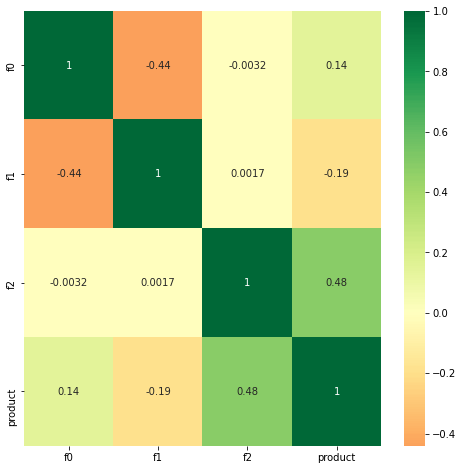

None

In [4]:
display (check(df0))


Выводы по первому региону:
* Пропусков нет
* Дубликатов нет
* Самый высокий уровень корреличии 0,48 с признаком f2

### Изучение данных второй регион

'***********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


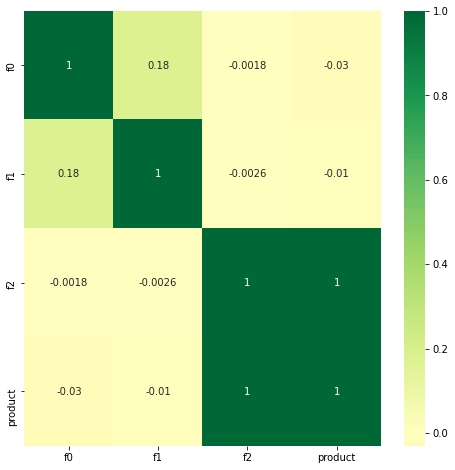

None

In [5]:
display (check(df1))

Выводы по первому региону:
* Пропусков нет
* Дубликатов нет
* Второй регион отличается по корреляции, признак f2 здесь максимально влияет на значения в product, в первом регионе этот признак не полностью влияет на резульатат, но самый значимый

### Изучение данных второй регион

'***********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


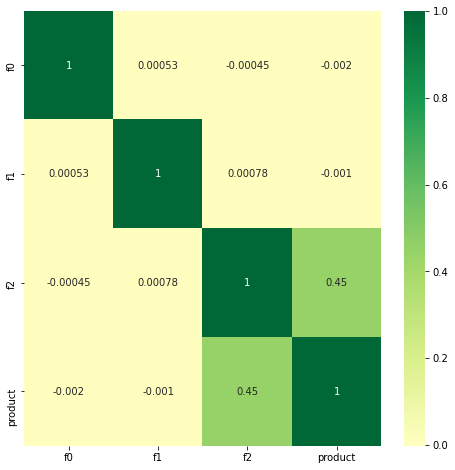

None

In [6]:
display (check(df2))

Выводы по первому региону:
* Пропусков нет
* Дубликатов нет
* Третий ригион похож на второй по корреляции, признак f2 на уровне 0,45 это ниже, чем максимальная единица, но другие признаки не оказывают влияния, а других данных данных нет, поэтому тут также f2 полностью влияет на результат

Удаляем во всех датафреймах стоблец id - индивидуальный номер скважины, это порядковый номер, который нам не пригодится, так как нет задач по выделению каких то конкретных скважин и идентификации их.

In [7]:
df0.drop(columns='id', inplace=True)
df1.drop(columns='id', inplace=True)
df2.drop(columns='id', inplace=True)

Проверим уникальные значения и количество в столбце product - запас нефти

In [8]:
def check_numbers (dataframe):
    display ('*******'*5)
    display (dataframe['product'].unique())
    display (dataframe['product'].nunique())
    display(dataframe['product'].value_counts())
display (check_numbers(df0))
display (check_numbers(df1))
display (check_numbers(df2))

'***********************************'

array([105.28006184,  73.03775027,  85.26564713, ...,  64.37544259,
        74.04076435, 149.63324561])

100000

0.000000      1
30.141653     1
56.573577     1
50.182301     1
88.989990     1
             ..
146.560758    1
155.729658    1
27.829511     1
85.382946     1
154.424007    1
Name: product, Length: 100000, dtype: int64

None

'***********************************'

array([  3.17910258,  26.95326103, 134.76630516, 137.94540774,
        84.03888568, 110.99214671,  53.90652206,   0.        ,
       107.81304413,  57.08562465,  30.13236361,  80.85978309])

12

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

None

'***********************************'

array([ 27.75867323,  56.06969663,  62.87191005, ..., 157.08007975,
        51.79525299, 102.77576749])

100000

0.000000      1
53.211205     1
37.811021     1
84.266951     1
38.939298     1
             ..
122.326832    1
34.629840     1
3.577922      1
0.937771      1
49.640390     1
Name: product, Length: 100000, dtype: int64

None

Есть только одна особенность, в первом и третьем регоине 10000 значений, значит количество скважин такое же, во втором регионе всего 12 скважин, для анализа это конечно проще.

## Обучение и проверка модели

Разбиваем каждый датафрейм на тренировочную и валидационную выборку в пропорции 75%/25%

Первый регион

In [9]:
features_train0, features_valid0, target_train0, target_valid0 = train_test_split(
   df0.drop(['product'], axis=1), df0['product'], test_size=0.25, random_state=42)

Второй регион

In [10]:
features_train1, features_valid1, target_train1, target_valid1 = train_test_split(
   df1.drop(['product'], axis=1), df1['product'], test_size=0.25, random_state=42)

Третий регион

In [11]:
features_train2, features_valid2, target_train2, target_valid2 = train_test_split(
   df2.drop(['product'], axis=1), df2['product'], test_size=0.25, random_state=42)

Обучаю модель и делаю предсказания на валидационной выборке. 
На основе предсказаний рассчитываю два показателя (далее переношу в общую сводную таблицу):  
* RMSE  - Квадратный корень среднеквадратической ошибки (MSE), показывает отклонения между наблюдаемым значением и истинным значением.
* Средний запас нефти, вычисляю, как среднее от предсказаний

In [12]:
model = LinearRegression() 

In [13]:
model.fit(features_train0, target_train0) 
valid_predictions0 = model.predict(features_valid0)
rmse0 = mean_squared_error(target_valid0, valid_predictions0)**0.5
print("RMSE:", "{:.2f}".format(rmse0))
print("Средний запас предсказанного сырья:", "{:.2f}".format(valid_predictions0.mean()), 'тысяч баррелей')

RMSE: 37.76
Средний запас предсказанного сырья: 92.40 тысяч баррелей


In [14]:
model.fit(features_train1, target_train1) 
valid_predictions1 = model.predict(features_valid1)
rmse1 = mean_squared_error(target_valid1, valid_predictions1)**0.5
print("RMSE:", "{:.2f}".format (rmse1))
print("Средний запас предсказанного сырья::", "{:.2f}".format (valid_predictions1.mean()), 'тысяч баррелей')

RMSE: 0.89
Средний запас предсказанного сырья:: 68.71 тысяч баррелей


In [15]:
model.fit(features_train2, target_train2) 
valid_predictions2 = model.predict(features_valid2)
rmse2 = mean_squared_error(target_valid2, valid_predictions2)**0.5
print("RMSE:", "{:.2f}".format (rmse2))
print("Средний запас предсказанного сырья:", "{:.2f}".format (valid_predictions2.mean()), 'тысяч баррелей')

RMSE: 40.15
Средний запас предсказанного сырья: 94.77 тысяч баррелей


In [16]:
table = pd.DataFrame({
    "Первый регион": ["{:.2f}".format (rmse0), "{:.2f}".format (valid_predictions0.mean())],
    "Второй регион": ["{:.2f}".format (rmse1), "{:.2f}".format (valid_predictions1.mean())],
    "Третий регион": ["{:.2f}".format (rmse2), "{:.2f}".format (valid_predictions2.mean())]},
    index=['RMSE', 'Средний запас, тыс.баррелей'])
table

,Первый регион,Второй регион,Третий регион
RMSE,37.76,0.89,40.15
"Средний запас, тыс.баррелей",92.40,68.71,94.77


Первый, третий регионы похожи, большое отклонение между наблюдаемыми значениями и истинными 37 и 40, это много, т.к. наша единица измерения тысячи бараллей.  
В втором регионе меньше средний запас, но ранее выяснили, что там меньшее количество скважин и отклонение между наблюдаемым и истинным, поэтому результаты выше не значит, что этот регион хуже.

## Подготовка к расчёту прибыли

Рассчитываем достаточный объём сырья для безубыточной разработки новой скважины. Задаем переменной search_budget необходимый бюджет на разработку в регионе и переменной price_one_barrel - цены за тысячу баррелей.

In [17]:
search_budget = 10000000000
price_one_barrel = 450000

In [18]:
min_vol_for = search_budget/price_one_barrel/200
display ("{:.2f}".format(min_vol_for))

'111.11'

Достаточный объем для безубыточной разработки  111.11 тысяч баррелей

Сравниваем полученный объём сырья для безубыточной разработки со средним запасом в каждом регионе, через функцию.

In [19]:
def volume (min_vol_for, mean_volume):
    if (mean_volume-min_vol_for)<0:
        print ('Запаса объема недостаточно, не хватает:', ("{:.2f}".format (min_vol_for-mean_volume)), 'тысяч баррелей (рассчитано по среднему запасу)')
    else:
        print ('Запаса объема достаточно, выше уровня безубыточности на:', ("{:.2f}".format (min_vol_for-mean_volume)), 'тысяч баррелей (рассчитано по среднему запасу)')
        

In [20]:
volume (min_vol_for, valid_predictions0.mean())

Запаса объема недостаточно, не хватает: 18.71 тысяч баррелей (рассчитано по среднему запасу)


In [21]:
volume (min_vol_for, valid_predictions1.mean())

Запаса объема недостаточно, не хватает: 42.40 тысяч баррелей (рассчитано по среднему запасу)


In [22]:
volume (min_vol_for, valid_predictions2.mean())

Запаса объема недостаточно, не хватает: 16.34 тысяч баррелей (рассчитано по среднему запасу)


В каждом регионе запаса недостаточно при сравнении со средним запасом, но нельзя сделать вывод о прибыльности, поэтому нужно сдедать рассчет прибыли.

## Расчёт прибыли и рисков 

Применяем технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
Расчитываю среднюю прибыль, 95%-й доверительный интервал и риск убытков. Так мы узнаем с 95% среднее будет в данном диапазоне.  
Убыток — это отрицательная прибыль.  

In [70]:
total_oil_well = 500
best_oil_well = 200
result = []
def revenue(target, predict, best_oil_well):
    probs_sorted = predict.sort_values(ascending=False)
    selected = target[probs_sorted.index][:best_oil_well]
    return (price_one_barrel * selected.sum()) - search_budget

def bootstrap(target_test, predict):
    state = np.random.RandomState(42)   
    values = []
    target_test = target_test.reset_index(drop=True)
    predict = pd.Series(predict)
    for i in range(1000):
        target_subsample = target_test.sample(n=total_oil_well, replace=True, random_state=state) 
        probs_subsample = predict.loc[target_subsample.index.to_list()]
        values.append (revenue(target_subsample, probs_subsample, best_oil_well))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    mean = values.mean()

    print("Средняя прибыль:", "{:.2f}".format(mean))
    print("2.5%-квантиль:", "{:.2f}".format(lower))
    print("97.5%-квантиль:", "{:.2f}".format(upper))

    values_loss = [num for num in values if num < 0]
    risk = len(values_loss)/len(values)
    percentage_risk = "{:.0%}".format(risk)
    print("Риск убытков:", percentage_risk)
    
    result.append(["{:.2f}".format(mean), "{:.2f}".format(lower), "{:.2f}".format(upper), percentage_risk])

In [71]:
bootstrap(target_valid0, valid_predictions0)

Средняя прибыль: 427847560.46
2.5%-квантиль: -97249829.57
97.5%-квантиль: 954215192.71
Риск убытков: 6%


In [72]:
bootstrap(target_valid1, valid_predictions1)

Средняя прибыль: 511362776.20
2.5%-квантиль: 98870649.90
97.5%-квантиль: 940720511.65
Риск убытков: 1%


In [73]:
bootstrap(target_valid2, valid_predictions2)

Средняя прибыль: 402575607.51
2.5%-квантиль: -137162225.07
97.5%-квантиль: 929887528.03
Риск убытков: 7%


In [74]:
result

[['427847560.46', '-97249829.57', '954215192.71', '6%'],
 ['511362776.20', '98870649.90', '940720511.65', '1%'],
 ['402575607.51', '-137162225.07', '929887528.03', '7%']]

In [75]:
result = pd.DataFrame(result, 
             columns=['Средняя прибыль, руб.', 'Квантиль 2,5 ','Квантиль 97,5','Риск убытков, %'],
             index  =['Регион 1','Регион 2','Регион 3']
            )
display(result)

,"Средняя прибыль, руб.","Квантиль 2,5","Квантиль 97,5","Риск убытков, %"
Регион 1,427847560.46,-97249829.57,954215192.71,6%
Регион 2,511362776.20,98870649.90,940720511.65,1%
Регион 3,402575607.51,-137162225.07,929887528.03,7%


На основе рассчета прибыли и рисков можно сделать следующие выводы:   
* наименьший риск во втором регионе 2 - 1%  
* наша цель оставить регионы где вероятность убытков меньше 2.5%, только регион 2 подходит по данное условие  
* Если посмотреть на доверительный интервал, то видно, почему риск  в 1 и 3 регионе выше, есть скажины с отрицательной прибылью, если вспомнить, что в этих регионах при этом большое количество скважин, то риск выше. В регионе 2 напротив доверительный интервал только положительные значения, риск минимален.

## Общий вывод

Не первом этапе были изучены данные, не было выявлено пропущенных значений, дубликатов, аномалий. Второй регион значимо отличался по меньшему количеству скважин.

Произведено обучение модели линейной регрессии, второй регион показал показал наименьшую ошибку между прогнозируемыми и наблюдаемыми значениями, но средний запас был ниже.

In [76]:
table

,Первый регион,Второй регион,Третий регион
RMSE,37.76,0.89,40.15
"Средний запас, тыс.баррелей",92.40,68.71,94.77


Произведены рассчеты прибыли доверительного интервала 95% и риска убытков.  
Наименший риск, с большей прибылью в регионе 2.  
Модель предсказывает более точный результат именно по этому региону. 
Второй регион предпочтителен для старта разработки месторождений.

In [78]:
result

,"Средняя прибыль, руб.","Квантиль 2,5","Квантиль 97,5","Риск убытков, %"
Регион 1,427847560.46,-97249829.57,954215192.71,6%
Регион 2,511362776.20,98870649.90,940720511.65,1%
Регион 3,402575607.51,-137162225.07,929887528.03,7%


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован